# CS498PS - Lab 0

In [1]:
import numpy as np
import math
from scipy.io import wavfile
import matplotlib.pyplot as plt
import sounddevice as sd

In [2]:
def normalize(arr, dtype = "PCM"): 
    if dtype == "PCM":
        return (2*(arr - np.min(arr)) / (np.max(arr) - np.min(arr) - 1)) * np.iinfo(np.float32).max

Below you will find a series of tasks that will help you get started with audio processing using Python. We will start with learning how to generate test sounds, how to read/write audio files, how to perform simple waveform editing and finally how to use real time audio I/O. Look at the provided hints and try to figure out how to do these tasks on your own. The instrctions are intentionally vague so that you practice your problem solving. If you get stuck, talk to me or our TAs for more hints. Make sure that any necessary soundfiles are inside a subdirectory called "data" at the same file location as your notebook.

Have fun!

## Exercise 1. Generating and playing basic sounds

It is important to be able to generate multiple types of test sounds to test various parts of an audio processing chain. Some of the most important ones are sinusoids, chirps, and certain types of noise. For this exercise you need to generate the following test signals, at a sampling rate of 8kHz and for a duration of a second. Plot them if you like and see if they look right. You will probably have to zoom into the plots to check these waveforms. Also, play these sounds from your computer’s speakers (IMPORTANT: Turn your computer’s volume down, some of these sounds might be loud!)

Useful numpy functions: ```random.randn```, ```sin```, ```linspace```, ```logspace```, ```fromfile```


This function can help you play a sound from a notebook. The ```rate``` parameter is the *sampling rate*, i.e. how many sound samples to play per second (so if you give this function an array of length 8000 and use a rate of 8000, it will play a sound for one second). We will be talking amore about this parameter during the next lecture, but for now this should be enough info to get you going.

In [3]:
# Make a sound player function that plays array "x" with a sample rate "rate", and labels it with "label"
def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    if label is '':
        display( Audio( x, rate=rate))
    else:
        display( HTML( 
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
        '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
        ))

Let's start by generating white noise. Complete the code below for it.

In [6]:
# Function that returns noise samples
def make_noise( duration=1, sample_rate=8000):
    sample = [None] * sample_rate
    return np.random.randn(sample_rate * duration)
    #Sample_rate * duration is guassian distribution
# Generate it
x = make_noise()

# Play the generated sound
sound( x, rate=8000, label='Noise')

Noise


Generate a sinusoid with a frequency of 440 Hz

In [7]:
# Function that returns a sinusoid
def make_sine( frequency=440, duration=1, sample_rate=8000):
    #440 is the # of times we want to see a sine wave
    #2pi is the period of a sin wave
    return np.array([np.sin((frequency * 2 * math.pi) / sample_rate * i) for i in range (sample_rate * duration)])
# Generate it
x = make_sine()


# Play the generated sound
sound( x, label='440Hz tone')

440Hz tone


Generate a "linear chirp" from 0 Hz to 4 kHz (do not use a chirp function, write the code yourself). What is a chirp you ask? I don't know, google it ...

In [8]:
# Function that returns noise samples
def make_chirp( duration=1, sample_rate=44100):
    target = 4000
    return np.array([np.sin(( 2 * math.pi + ( (target * i) / sample_rate) ) / sample_rate * i) for i in range (sample_rate * duration)])

# Generate it
x = make_chirp()

# Play the generated sound
sound( x, rate=44100, label='Chirp')

Chirp


Generate a sinusoidal tone with an exponentially decreasing amplitude from 100 to 0.0001

In [9]:
# Function that returns noise samples
def make_ping( frequency=440, duration=1, sample_rate=8000, start = 100):
    #For this one we used an exponential decay function and plugge d
    #y = ae**-kt
    k = -(math.log(start / start**-1) / (duration * sample_rate))
    return np.array([(start * math.exp(k*i)) * np.sin((frequency * 2 * math.pi) / sample_rate * i) for i in range (int(sample_rate * duration))])

# Generate it
x = make_ping()

# Play the generated sound
sound( x,8000, label='ping')

ping


You will now make a stereo file. This is represented as a 2d array, one part containing the left channel and the other containing the right channel. For the left channel generate a quarter-second sinusoidal tone of frequency 523.24Hz with an exponentially decaying amplitude from 100 to 0.0001. For the right channel do the same thing but use a frequency of 784Hz.  Start the right channel tone after a quarter second. Play this and verify that it sounds ok (it should sound like a video game “ping-pong” sound).

In [28]:
# Function that returns noise samples
def make_pingpong( sample_rate=8000):
    pingpong = np.zeros((2, sample_rate))
    quarter_sample = int(sample_rate * .25)
    left_ping = make_ping(523.24, .25, 8000, 100)
    right_ping = make_ping(784, .25, 8000, 100)
    pingpong[0, :len(left_ping)] = left_ping
    pingpong[1, len(left_ping):math.floor(sample_rate * 0.5)] = right_ping
    
    return pingpong

    
    
# Generate it
sr = 8000
x = make_pingpong(sr)

# Play the generated sound
sound( x, sr, label='ping-pong')

ping-pong


Download and load into python the file [ https://drive.google.com/uc?export=download&id=1BZ5qqH34-GCoJcSoCMxo7YWS0kwX3BSz ]. It contains a sound waveform encoded as a series of 16-bit values. Find out what its sample rate is (there’s no trick here, this one is trial and error). Show some examples where it sounds wrong and explain why.

In [13]:
x = np.fromfile("data/lab_0/handel.dat", dtype = np.int16)
wrong_sample_rate = 8000
another_wrong_sample_rate = 16000
right_sample_rate = 23000

sound( x, rate=wrong_sample_rate, label='Sounds off')
sound( x, rate=another_wrong_sample_rate, label='Sounds off too')
sound( x, rate=right_sample_rate, label='Sounds right!')

Sounds off


Sounds off too


Sounds right!


## Exercise 2. Saving sounds

What good are sounds if we can’t store them? For most of this class we will be using what is known as a PCM format (more on Tuesday). The most popular of these formats is the WAVE file, which we will use most often. When saving a sound to a file we need to be careful and make sure we don’t lose any information.

Take the “ping-pong” sound from above and save it to a WAVE file. Play the file back, or open it with an audio editor and find out if there’s anything wrong. If so, find a way to fix it.

Useful python package: ```scipy.io.wavfile```

In [36]:
sr = 8000
pingpong = np.transpose(make_pingpong(sr), (1, 0))
pingpong = pingpong.astype(np.float64)
wavfile.write("pingpong.wav", sr, pingpong)

## Exercise 3. Basic Sound Editing

Here we will learn to do some simple manipulations of sounds. Ordinarily you would do this with an audio editor with a graphical interface, but hey life sucks and you have to do this with code.

Useful python commands:  ```scipy.io.wavfile.wavread, numpy.hstack```

Load the file [ https://drive.google.com/uc?export=download&id=1CbCTIMNDfJUpCRpYMK9IFdb-jQJgZbmP ] and listen to it. Clearly something is wrong. Try to fix the problem using code.


In [37]:
signal = wavfile.read("data/1234.wav")[1]
quarter = len(signal) // 4
print(quarter)
x= np.concatenate((signal[:quarter], signal[2*quarter:3*quarter], signal[quarter:2*quarter], signal[3*quarter:]))
print(x)
sound( x, rate=16000, label='Fixed sound') 

14826
[  9   1   1 ... -31 -24 -27]


Fixed sound


Use the above file to create a countdown instead.



In [38]:
x = np.concatenate((signal[3*quarter:], signal[quarter:2*quarter], signal[2*quarter:3*quarter], signal[:quarter]))

sound( x, rate=16000, label='Countdown')

Countdown


Load the file [ https://drive.google.com/uc?export=download&id=1C6xgDOS0sQd6zCNbnRVBwbZJ5qoUyETg ] . There’s something wrong here too. Fix it!

In [41]:
sr, uneven_signal = wavfile.read("data/uneven.wav")

lin_inc = [(i / (len(uneven_signal) // 2)) + 2 for i in range (len(uneven_signal) //2 +1 ) ]
triangle = np.concatenate((lin_inc, lin_inc[::-1]))
even_signal = uneven_signal * triangle[len(uneven_signal)]

#sqrt_inc = [15*math.sqrt((i) / len(uneven_signal//2)) + 1 for i in range(len(uneven_signal // 2) +1)]
#even_signal = uneven_signal * np.concatenate((sqrt_inc, sqrt_inc[::-1]))[:len(uneven_signal)]
#plt.plot(np.concatenate((sqrt_inc, sqrt_inc[::-1]))[:len(uneven_signal)])

#exp_inc = [8*math.exp(i - len(uneven_signal) / 2) + 1 for i in range(len(uneven_signal) // 2 + 1)]
#exp_spike = np.concatenate((exp_inc, exp_inc[::-1]))[:len(uneven_signal)]
#plt.plot(exp_spike)
#even_signal = uneven_signal+exp_spike
sound( even_signal, sr, label='repaired')

repaired


Load the two files [ https://drive.google.com/uc?export=download&id=1Bnlff8-cMeNRUgqtfY6nu9psEAA_-Alm ] and [ https://drive.google.com/uc?export=download&id=1BlAzhHEJCu81VybUHOKOStkVlXSWUYeO ]. They are roughly at the same tempo and you want to make a music mix out of them. Play the first sound for two seconds, then fade it out over four seconds. While the first sound fades out the second one should fade in at the same speed. Congrats, you just learned how to (poorly) DJ in python!




In [42]:
m1 = wavfile.read("data/m1.wav")
m2 = wavfile.read("data/m2.wav")
sr = m1[0]

m1_s = m1[1]
m2_s = m2[1]
#Linear fade out of the m1.wav file 
m1_out = [(-i / (sr * 4)) + 1 for i in range(0, sr * 4)]


#linear fade in of the m2.wav file
m2_in = [(i / (sr * 4)) for i in range(0, sr * 4)]
m1_s = m1_s[:sr * 6]

#Process first song
full_m1 = m1_s[:sr * 2]
fade_m1 = m1_s[sr * 2: sr * 6]
fade_m1 = fade_m1 * m1_out

#Process second song
fade_m2 = m2_s[:sr*4]
fade_m2 = fade_m2 * m2_in
full_m2 = m2_s[sr*4:]

#Add two fades together to make a transition
transition = np.add(fade_m1, fade_m2)

x = np.concatenate((full_m1, transition, full_m2))



sound( x, rate=sr, label='Awesome mix')

Awesome mix


## Exercise 4. Real-time processing

In real-life you can’t just load an existing soundfile, process at your leisure and save it. You have to be able to process sound in real-time. This means that you will record tiny snippets of sound, quickly process each one and then move to the rest without looking back again. In this exercise we will try a couple of real-time things to get the hang of it. Interpreted languages is generally horrible for real-time systems, but we’ll stick with them since it’s much simpler than writing low-level code. In python you can use the package ```pysoundcard``` or ```sounddevice``` to get some low-level audio control. Open an audio stream with a sample rate of 16kHz and a single channel. Use a buffer size of 1024 samples.

You will then create a loop in which we get a snippet of sound from the microphone at each pass. Inside the loop you will read from the stream (which should be taking samples off the microphone). Using this, measure the standard deviation of each incoming sound snippet of sound and after eight seconds of recording plot these as a sequence.

Useful python commands:  ```pysoundcard.Stream.read```, ```sounddevice.InputStream```

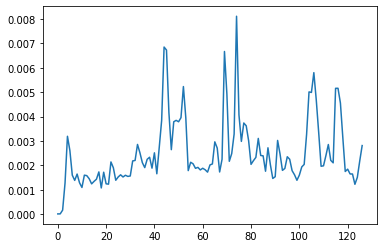

In [43]:
sd.default.samplerate = 16000

data = []
def callback(indata, frames, time, status):
    data.append(np.std(indata))
    

with sd.InputStream(samplerate = 16000, blocksize = 1024, callback = callback):
    sd.sleep(8192)

plt.plot(data)
    


Now let’s try to add some output as well. We will make a robot voice effect that makes use of a ring modulator. This is the same effect that’s been used to generate robot voices for many older films and TV shows (e.g. the Daleks in Dr. Who).

We will reuse the loop that we made above, but this time we will additionally have an audio output. Do the same as above, but this time you can also write to the stream to send a buffer of samples to the speaker. For a test you can simply pass the input buffer from read to write, and this would simply play from the speakers the sounds you make to the microphone (tip #1: wear headphones to avoid a feedback loop! tip #2: Every time you put on headphones set the volume to a very low value to avoid any painful surprises). 

Once you verify that a passthrough works, multiply each input snippet with a a 440Hz sine and send that to the output to create a voice transformation. If successful, it should sound robotic. Congrats, you just made your first real-time audio effect!

Useful python commands:  ```pysoundcard.Stream.write```, ```sounddevice.Stream```

In [46]:
sd.default.samplerate = 16000
data = []
def callback(indata, outdata, frames, time, status):
    sine = np.reshape(make_sine(frequency = 440, sample_rate = 1024), (1024, 1))
    indata =sine * indata
    outdata[:] = indata
    
    
with sd.Stream(samplerate = 16000, blocksize = 1024, callback = callback, channels = 1):
    input()
    